<a href="https://colab.research.google.com/github/thirayume/muangtai/blob/main/Muangtai_PGSQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Muangtai PostgreSQL Database export query to CSV**

In [1]:
# @title Mount Google Drive (if need)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# @title Define secrets

from google.colab import userdata
host = userdata.get('host')
port = userdata.get('port')
database = userdata.get('database')
user = userdata.get('user')
password = userdata.get('password')

In [231]:
# @title Install dependencies (if need)

!pip install psycopg2 pandas pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00


In [234]:
# @title Import dependencies

import psycopg2

from datetime import datetime

import numpy as np
import pandas as pd
from pandas import plotting

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected = True)

import fastai

import warnings
import os
from pathlib import Path
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.autograd import Variable

import pmdarima as pm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from math import sqrt

# plt.style.use('fivethirtyeight')
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout = True)
plt.rc("axes", labelweight = "bold", labelsize = "large", titleweight = "bold", titlesize = 12, titlepad = 10)

In [3]:
# @title Define data path

data_path = Path('/content/drive/MyDrive/Colab Notebooks/Muangtai')

%cd {data_path}
%ls

/content/drive/MyDrive/Colab Notebooks/Muangtai
'Muangtai - PGSQL.ipynb'   output.csv


In [5]:
# @title Connect to the PostgreSQL database

conn = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password,
)
conn

<connection object at 0x7cd3686db100; dsn: 'user=postgres password=xxx dbname=muangtaipanit-hatyai_muangtai-online host=monthong.adiwit.co.th port=5433', closed: 0>

In [ ]:
# @title Define a SQL to create a "view_picking_list" (if not found)

sql = """
      DROP VIEW IF EXISTS view_fact_picking_lists;

      CREATE OR REPLACE VIEW view_fact_picking_lists
      AS
      select
                   fact_picking_lists.id as fact_picking_lists__id
                  ,dim_dates."year" || '-' || dim_dates."month" || '-' || dim_dates."date" as fact_picking_lists__date
                  ,to_char((LPAD((dim_times.hour_of_day || ''), 2, '0') || '' || LPAD((dim_times.minute_of_hour || ''), 2, '0') || '00')::time,'HH24:MI:SS') as fact_picking_lists__time
                  ,GREATEST(
                      dim_picking_lists.created_at,
                      dim_picking_lists.updated_at,
                      dim_picking_lists.moderated_at, (
                      dim_picking_lists.document_date + '08:30:01'::time)
                  ) as lasted_updated_at
                  ,dim_picking_lists.document_number as dim_picking_lists__document_number
                  ,dim_picking_lists.id as dim_picking_lists__id
                  ,dim_stock_keeping_units.id as dim_stock_keeping_units__sku_id
                  ,fact_picking_lists.quantity as fact_picking_lists__quantity
                  -- , (fact_picking_lists.quantity  * multiply_hierarchy_unit_quantity(fact_picking_lists.stock_keeping_unit_id)) as liters
                  ,dim_families.is_alcoholic as dim_families__is_alcoholic
                  ,dim_picking_lists.owner_id as dim_picking_lists__owner_id
                  ,dim_picking_lists.owner_type as dim_picking_lists__owner_type
      from		    fact_picking_lists
      inner join	dim_dates on dim_dates.id = fact_picking_lists.date_id
      inner join	dim_times on dim_times.id = fact_picking_lists.time_id
      inner join	dim_families on dim_families.id = fact_picking_lists.family_id
      inner join	dim_brands on dim_brands.id = dim_families.brand_id
      inner join 	dim_picking_lists on dim_picking_lists.id = fact_picking_lists.picking_list_id
      inner join 	dim_stock_keeping_units on dim_stock_keeping_units.id = fact_picking_lists.stock_keeping_unit_id
      where       fact_picking_lists.deleted_at is null
      and         dim_picking_lists.moderation_status = 1 -- Approved
      and         fact_picking_lists.direction = 'outbound'
      order by    fact_picking_lists.id desc
      """

In [6]:
# @title Define a SQL query to select data from a "fact_picking_lists" like in a View

sql = """
      select
                   fact_picking_lists.id as fact_picking_lists__id
                  ,dim_dates."year" || '-' || dim_dates."month" || '-' || dim_dates."date" as fact_picking_lists__date
                  ,to_char((LPAD((dim_times.hour_of_day || ''), 2, '0') || '' || LPAD((dim_times.minute_of_hour || ''), 2, '0') || '00')::time,'HH24:MI:SS') as fact_picking_lists__time
                  ,GREATEST(
                      dim_picking_lists.created_at,
                      dim_picking_lists.updated_at,
                      dim_picking_lists.moderated_at, (
                      dim_picking_lists.document_date + '08:30:01'::time)
                  ) as lasted_updated_at
                  ,dim_picking_lists.document_number as dim_picking_lists__document_number
                  ,dim_picking_lists.id as dim_picking_lists__id
                  ,dim_stock_keeping_units.id as dim_stock_keeping_units__sku_id
                  ,fact_picking_lists.quantity as fact_picking_lists__quantity
                  -- , (fact_picking_lists.quantity  * multiply_hierarchy_unit_quantity(fact_picking_lists.stock_keeping_unit_id)) as liters
                  ,dim_families.is_alcoholic as dim_families__is_alcoholic
                  ,dim_picking_lists.owner_id as dim_picking_lists__owner_id
                  ,dim_picking_lists.owner_type as dim_picking_lists__owner_type
      from		    fact_picking_lists
      inner join	dim_dates on dim_dates.id = fact_picking_lists.date_id
      inner join	dim_times on dim_times.id = fact_picking_lists.time_id
      inner join	dim_families on dim_families.id = fact_picking_lists.family_id
      inner join	dim_brands on dim_brands.id = dim_families.brand_id
      inner join 	dim_picking_lists on dim_picking_lists.id = fact_picking_lists.picking_list_id
      inner join 	dim_stock_keeping_units on dim_stock_keeping_units.id = fact_picking_lists.stock_keeping_unit_id
      where       fact_picking_lists.deleted_at is null
      and         dim_picking_lists.moderation_status = 1 -- Approved
      and         fact_picking_lists.direction = 'outbound'
      order by    fact_picking_lists.id desc
      """

In [7]:
# @title Create a cursor object to execute queries to dataframe

with conn.cursor() as cursor:
  # Execute the query
  cursor.execute(sql)
  columns = [desc[0] for desc in cursor.description]
  # Fetch all rows from the query result
  rows = cursor.fetchall()

  # Create dataframe
  df = pd.DataFrame(rows, columns=columns)

In [8]:
# @title Close the connection
conn.close()

In [9]:
# @title Save to csv for local work

# Convert the DataFrame to a dictionary with lists as values
data_dict = df.to_dict(orient="list")

# Specify the output file path
output_file = data_path/"output.csv"

# Write the query result to CSV
df.to_csv(output_file)

In [4]:
# @title Read CSV from local

output_file = data_path/"output.csv"
df = pd.read_csv(output_file)

In [32]:
# @title Format Date and Time and Index

df['fact_picking_lists__podatetime'] = pd.to_datetime( df['fact_picking_lists__date']  + ' ' + df['fact_picking_lists__time'], infer_datetime_format=True)
df['lasted_updated_at'] = pd.to_datetime(df['lasted_updated_at'], infer_datetime_format = True)
df['fact_picking_lists__date'] = pd.to_datetime(df['lasted_updated_at'], infer_datetime_format = True)

# df.index =  df['fact_picking_lists__id']

In [33]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [34]:
df.head(5)

,fact_picking_lists__id,fact_picking_lists__date,fact_picking_lists__time,lasted_updated_at,dim_picking_lists__document_number,dim_picking_lists__id,dim_stock_keeping_units__sku_id,fact_picking_lists__quantity,dim_families__is_alcoholic,dim_picking_lists__owner_id,dim_picking_lists__owner_type,fact_picking_lists__podatetime
0,9c4ab3df-ff4a-4fc6-879f-29525fab26f1,2024-06-15 17:16:33,17:16:00,2024-06-15 17:16:33,78379,9c4ab3df-b951-4052-933f-f9b0c503b07d,73337333-7333-7333-7333-733373337333,1.00,True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2024-06-15 17:16:00
1,9c4ab3df-fc3b-4d63-9fc5-6c4ef371d4df,2024-06-15 17:16:33,17:16:00,2024-06-15 17:16:33,78379,9c4ab3df-b951-4052-933f-f9b0c503b07d,0979879a-c604-441d-afa2-91b8c68e7fc1,1.00,NaN,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2024-06-15 17:16:00
2,9c4ab3df-f932-4272-a88b-703d9dcd0517,2024-06-15 17:16:33,17:16:00,2024-06-15 17:16:33,78379,9c4ab3df-b951-4052-933f-f9b0c503b07d,64646464-6464-6464-6464-646464646464,1.00,NaN,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2024-06-15 17:16:00
3,9c4ab3df-f62f-46b0-8120-966184772cc0,2024-06-15 17:16:33,17:16:00,2024-06-15 17:16:33,78379,9c4ab3df-b951-4052-933f-f9b0c503b07d,8cc85ca5-dda3-42d4-b4a3-5d74913a10b2,3.00,True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2024-06-15 17:16:00
4,9c4ab3df-f31c-4bef-a42e-b7872168006a,2024-06-15 17:16:33,17:16:00,2024-06-15 17:16:33,78379,9c4ab3df-b951-4052-933f-f9b0c503b07d,9cb8814c-5184-4131-ae09-6691399b7a70,1.00,True,43666aa9-17ca-4b2e-870d-79ef49d6be33,App\Models\Syndicate,2024-06-15 17:16:00


In [23]:
df.describe()

,lasted_updated_at,dim_picking_lists__document_number,fact_picking_lists__quantity,fact_picking_lists__podatetime
count,31081,31081.000000,31081.000000,31081
mean,2023-11-24 06:25:10.491457792,74971.264663,39.699044,2023-10-25 16:48:52.554293504
min,2023-04-24 16:59:36,71475.000000,1.000000,2022-04-11 17:04:00
25%,2023-08-04 11:35:30,73238.000000,4.000000,2023-06-24 08:43:00
50%,2023-12-06 15:38:43,74960.000000,10.000000,2023-10-28 16:06:00
75%,2024-02-28 15:14:41,76711.000000,30.000000,2024-02-27 09:30:00
max,2024-06-15 17:16:33,78379.000000,2000.000000,2024-06-15 17:16:00
std,NaN,2001.219507,96.662228,NaN


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31081 entries, 0 to 31080
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   fact_picking_lists__id              31081 non-null  object        
 1   fact_picking_lists__date            31081 non-null  object        
 2   fact_picking_lists__time            31081 non-null  object        
 3   lasted_updated_at                   31081 non-null  datetime64[ns]
 4   dim_picking_lists__document_number  31081 non-null  int64         
 5   dim_picking_lists__id               31081 non-null  object        
 6   dim_stock_keeping_units__sku_id     31081 non-null  object        
 7   fact_picking_lists__quantity        31081 non-null  float64       
 8   dim_families__is_alcoholic          17542 non-null  object        
 9   dim_picking_lists__owner_id         31081 non-null  object        
 10  dim_picking_lists__own

In [25]:
df.isnull().sum()

fact_picking_lists__id                    0
fact_picking_lists__date                  0
fact_picking_lists__time                  0
lasted_updated_at                         0
dim_picking_lists__document_number        0
dim_picking_lists__id                     0
dim_stock_keeping_units__sku_id           0
fact_picking_lists__quantity              0
dim_families__is_alcoholic            13539
dim_picking_lists__owner_id               0
dim_picking_lists__owner_type             0
fact_picking_lists__podatetime            0
dtype: int64

In [66]:
sku_ids = df['dim_stock_keeping_units__sku_id'].unique()
print(sorted(sku_ids))

['01670074-7124-4d8c-a5ea-83ae2e8fbe71', '0651ff55-0b29-4347-9860-7c4adc5dcb50', '06964cbe-9724-4331-aac9-a5d10787d0d9', '085673b7-a440-45d4-9167-c2fdb756b2b1', '0979879a-c604-441d-afa2-91b8c68e7fc1', '0acff31b-921d-4b59-aae6-813bb9362aee', '0bd166f5-82d6-4706-ac78-228656506a72', '10fb438f-26d5-4598-bde7-490a7b6ccceb', '11111111-1111-1111-1111-111111111111', '12242ad2-dd75-4e84-89e8-0e6123eb68b5', '12bcb219-cae0-4eed-8756-d535fe4acce4', '13131313-1313-1313-1313-131313131313', '15151515-1515-1515-1515-151515151515', '1666da92-e315-464e-bef8-ed9da70d67ff', '17171717-1717-1717-1717-171717171717', '18181818-1818-1818-1818-181818181818', '1e6277a0-bd66-44a0-b746-9eb97b29bfcd', '2328e46a-fb09-4d75-a526-e16659a11b3f', '2f4cabd0-e857-457a-9f58-61c1146f94ff', '30e6cd3d-146b-4c61-bac2-edccb5c5b373', '317cf546-c60b-4b81-aff1-90c3f812eb19', '31e6ab18-1131-45c2-b26f-3d06d4169549', '33333333-3333-3333-3333-333333333333', '37042d15-5858-4705-a664-d5c2f26f7744', '37b371c3-fb8e-41c6-9c0a-2043d921f489',

In [354]:
# @title Pivot SKU Sales by Month
pd.set_option("display.float_format", "{:,.0f}".format)

# df['month'] = df['fact_picking_lists__date'].dt.month.astype(str) + '-' + df['fact_picking_lists__date'].dt.year.astype(str)
# df['month'] = df['fact_picking_lists__podatetime'].dt.month.astype(str) + '-' + df['fact_picking_lists__podatetime'].dt.year.astype(str)
df['month'] = df['lasted_updated_at'].dt.month.astype(str) + '-' + df['lasted_updated_at'].dt.year.astype(str)
df['month'] = pd.to_datetime(df['month'], infer_datetime_format = True)

pivot = df.pivot_table(
    values='fact_picking_lists__quantity',
    index=['dim_stock_keeping_units__sku_id'],
    columns=['month'],
    aggfunc='sum',
    margins = True,
    fill_value = '0'
)
pivot = pivot.sort_values(by=['All'], ascending=False)
pivot

month,2023-04-01 00:00:00,2023-05-01 00:00:00,2023-06-01 00:00:00,2023-07-01 00:00:00,2023-08-01 00:00:00,2023-09-01 00:00:00,2023-10-01 00:00:00,2023-11-01 00:00:00,2023-12-01 00:00:00,2024-01-01 00:00:00,2024-02-01 00:00:00,2024-03-01 00:00:00,2024-04-01 00:00:00,2024-05-01 00:00:00,2024-06-01 00:00:00,All
dim_stock_keeping_units__sku_id,,,,,,,,,,,,,,,,
All,"1,342","34,420","120,864","143,645","136,966","13,585",404,"148,357","177,804","77,866","81,184","85,335","88,759","82,346","41,009","1,233,886"
73337333-7333-7333-7333-733373337333,"1,045","10,869","42,865","49,898","49,198","5,159",130,"55,647","60,631","25,975","27,721","31,827","27,199","28,278","13,052","429,494"
77337733-7733-7733-7733-773377337733,43,"4,251","18,790","20,708","19,934","2,297",125,"23,902","29,435","14,687","14,301","15,244","16,691","15,477","8,184","204,069"
3e44aa10-5b8f-4954-853d-b92878123bf9,0,"4,678","11,754","14,499","11,254",285,6,"13,367","16,672","6,218","7,239","7,033","6,428","6,291","2,594","108,318"
64646464-6464-6464-6464-646464646464,0,"3,367","9,060","9,995","8,744",763,23,"10,199","13,673","5,511","5,436","4,788","5,984","4,990","3,719","86,252"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3f8e3af9-2ff7-472c-beea-94a154b57416,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3b9acc74-b3ee-4e11-b598-bafacdd24429,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
70707070-7070-7070-7070-707070707070,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [355]:
pivot.T

dim_stock_keeping_units__sku_id,All,73337333-7333-7333-7333-733373337333,77337733-7733-7733-7733-773377337733,3e44aa10-5b8f-4954-853d-b92878123bf9,64646464-6464-6464-6464-646464646464,33333333-3333-3333-3333-333333333333,84848484-8484-8484-8484-848484848484,44444444-4444-4444-4444-444444444444,82828282-8282-8282-8282-828282828282,61616161-6161-6161-6161-616161616161,...,c710878f-8f65-4b2b-9df4-006868e11478,1e6277a0-bd66-44a0-b746-9eb97b29bfcd,77577757-7757-7757-7757-775777577757,55555555-5555-5555-5555-555555555555,74447444-7444-7444-7444-744474447444,3f8e3af9-2ff7-472c-beea-94a154b57416,3b9acc74-b3ee-4e11-b598-bafacdd24429,70707070-7070-7070-7070-707070707070,dd9c53f1-9415-4b76-87d4-2410b0cd70c3,663de7fe-07eb-437f-bffa-b16eb732ee7c
month,,,,,,,,,,,,,,,,,,,,,
2023-04-01 00:00:00,"1,342","1,045",43,0,0,44,0,85,0,2,...,0,0,0,0,0,0,0,0,0,0
2023-05-01 00:00:00,"34,420","10,869","4,251","4,678","3,367","2,647","1,625","2,053",968,"1,278",...,0,0,0,0,2,0,0,0,0,1
2023-06-01 00:00:00,"120,864","42,865","18,790","11,754","9,060","7,298","6,526","6,726","5,295","2,605",...,0,2,0,0,0,0,0,0,0,0
2023-07-01 00:00:00,"143,645","49,898","20,708","14,499","9,995","9,218","7,202","7,908","6,033","3,470",...,0,0,0,0,0,0,1,0,0,0
2023-08-01 00:00:00,"136,966","49,198","19,934","11,254","8,744","8,236","8,524","7,379","5,931","3,065",...,0,0,0,0,0,1,0,1,1,0
2023-09-01 00:00:00,"13,585","5,159","2,297",285,763,"1,048",676,977,444,383,...,0,0,0,0,0,0,0,0,0,0
2023-10-01 00:00:00,404,130,125,6,23,50,0,50,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-11-01 00:00:00,"148,357","55,647","23,902","13,367","10,199","8,832","8,896","8,647","6,243","3,204",...,0,0,0,0,0,0,0,0,0,0
2023-12-01 00:00:00,"177,804","60,631","29,435","16,672","13,673","11,859","9,255","10,729","8,164","4,353",...,0,0,0,0,0,0,0,0,0,0


In [356]:
sorted_sku = []
for sku, qty in pivot.iterrows():
  # qty1 = row[1]
  # print(sku, qty1)
  sorted_sku.append(sku)
sorted_sku.pop(0)

'All'

In [357]:
def plot_by_SKUs(sku_df):
  for i in range(len(sku_df)):
    print(sku_df[i])
    plt.figure(figsize=(6,3))
    my_df = pivot.T[sku_df[i]]
    my_df.drop(my_df.tail(1).index,inplace=True)
    my_df.astype(float).plot() # .plot(kind='bar')
    # plt.legend(pivot.columns, title=pivot.columns.name)
    plt.title(sku_df[i])
    plt.tight_layout()
    plt.show()

73337333-7333-7333-7333-733373337333


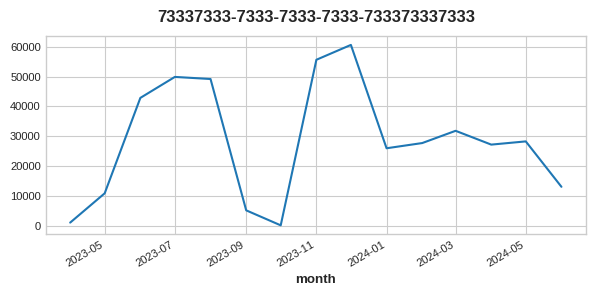

77337733-7733-7733-7733-773377337733


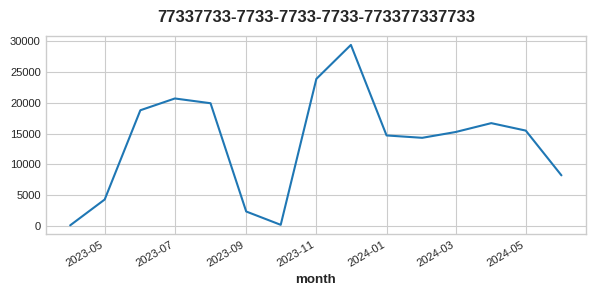

3e44aa10-5b8f-4954-853d-b92878123bf9


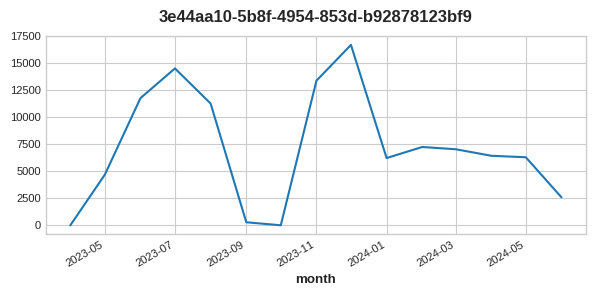

64646464-6464-6464-6464-646464646464


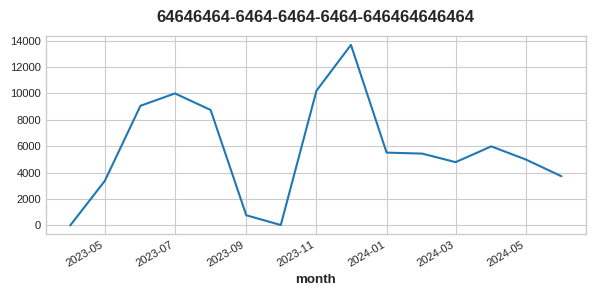

33333333-3333-3333-3333-333333333333


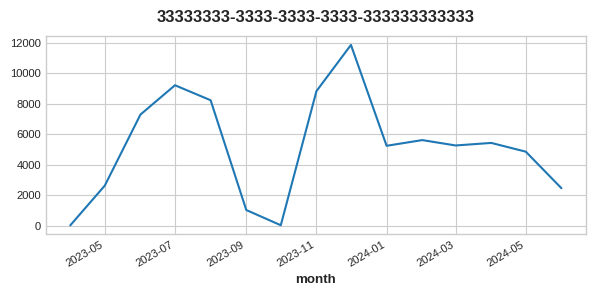

In [358]:
sample = sorted_sku[0:5]
plot_by_SKUs(sample)

In [359]:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [360]:
sample_sku = sorted_sku[0:1]
sample_sku

['73337333-7333-7333-7333-733373337333']

In [361]:
sample_df = pivot.T[sample_sku].reset_index()
sample_df.drop(sample_df.tail(1).index, inplace=True)
# sample_df.drop(0)
# sample_df = sample_df.loc[:, ~sample_df.columns.str.contains('^Unnamed')]
sample_df.columns = ['month', 'qty']
sample_df['month'] = pd.to_datetime(sample_df['month'], infer_datetime_format = True)
sample_df = sample_df.set_index(['month'])
sample_df

,qty
month,
2023-04-01,"1,045"
2023-05-01,"10,869"
2023-06-01,"42,865"
2023-07-01,"49,898"
2023-08-01,"49,198"
2023-09-01,"5,159"
2023-10-01,130
2023-11-01,"55,647"
2023-12-01,"60,631"


In [362]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2023-04-01 to 2024-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   qty     15 non-null     object
dtypes: object(1)
memory usage: 240.0+ bytes


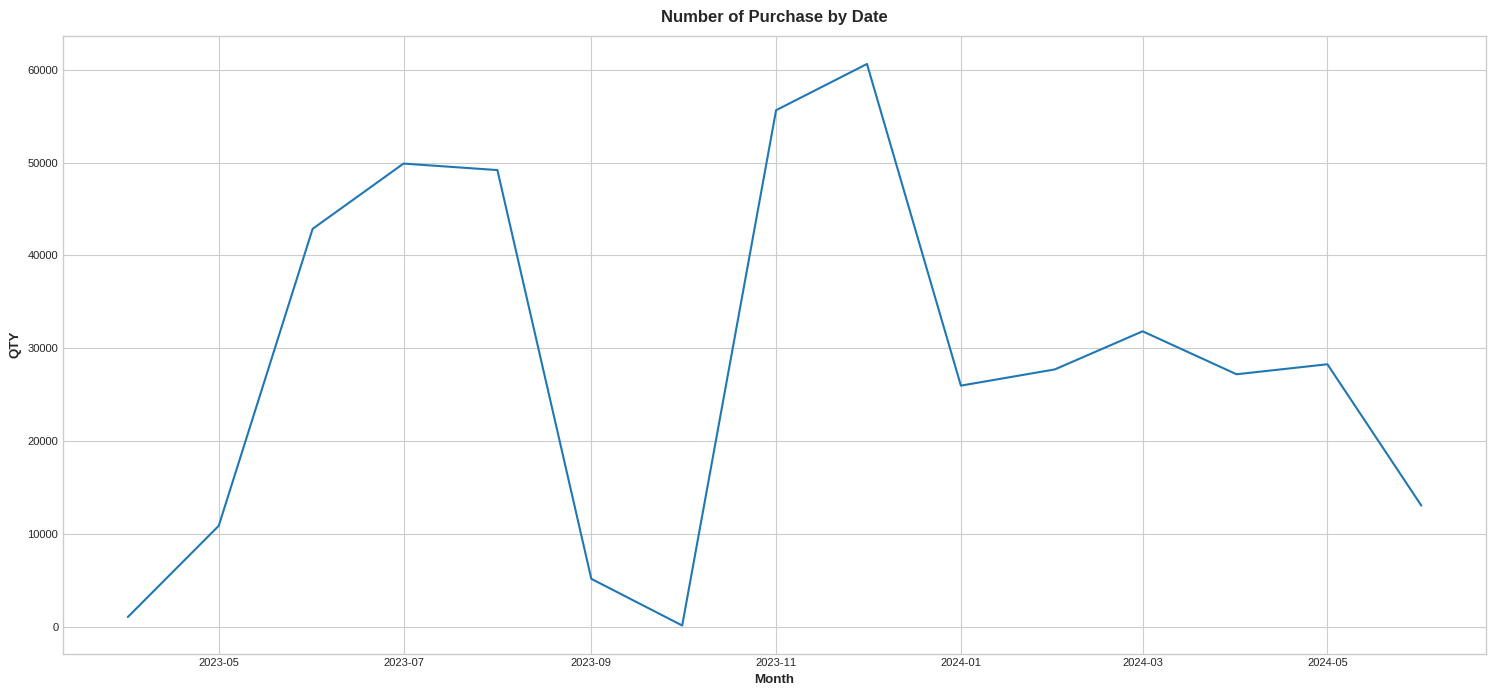

In [411]:
plt.figure(figsize = (15, 7))
plt.title("Number of Purchase by Date")
plt.xlabel('Month')
plt.ylabel('QTY')
plt.plot(sample_df)
plt.show()

### <center> Rolling Statistics

A rolling average is a great way to visualize how the dataset is trending. As the dataset provides counts by month, a window size of 12 will give the annual rolling average.

this plot include the rolling standard deviation to see how much the data varies from the rolling average.

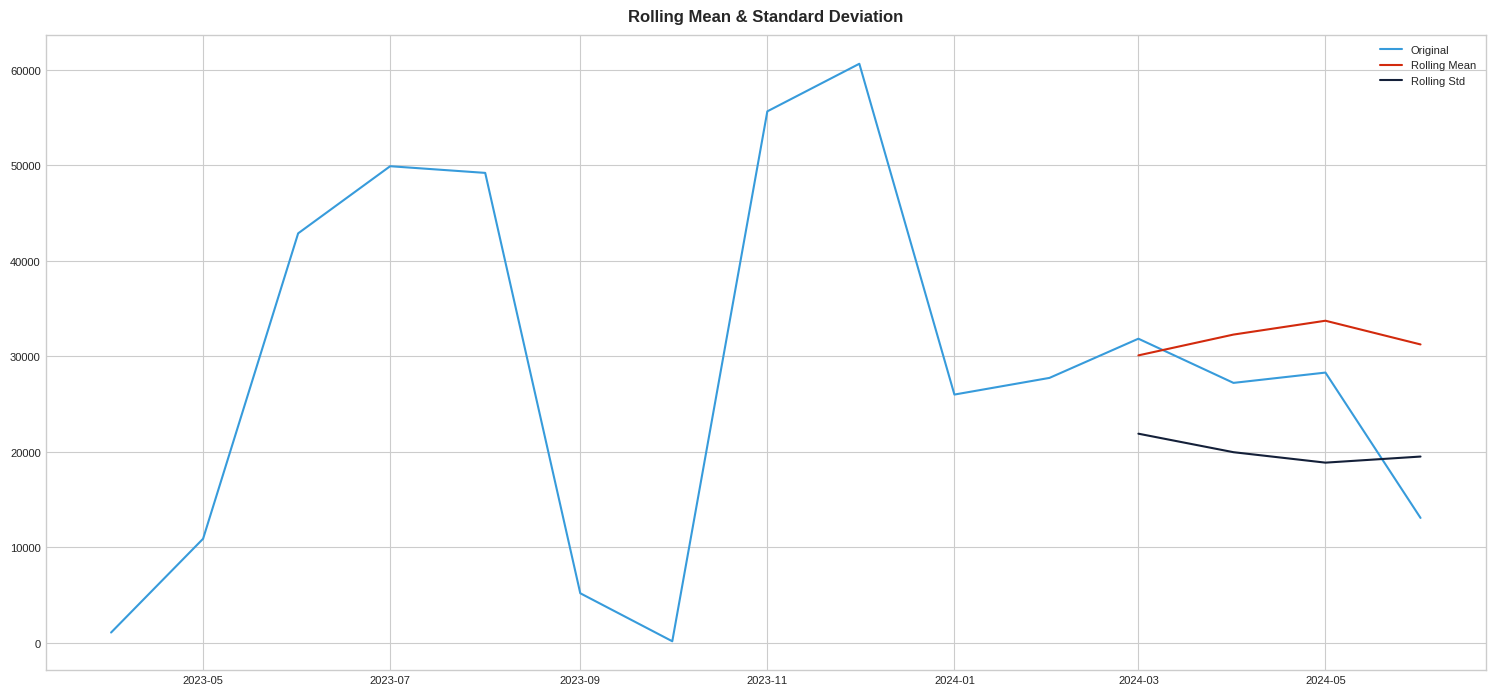

In [244]:
#Determine rolling statistics
sample_df["rolling_avg"] = sample_df["qty"].rolling(window = 12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
sample_df["rolling_std"] = sample_df["qty"].rolling(window = 12).std()

#Plot rolling statistics
plt.figure(figsize = (15, 7))
plt.plot(sample_df["qty"], color = '#379BDB', label = 'Original')
plt.plot(sample_df["rolling_avg"], color = '#D22A0D', label = 'Rolling Mean')
plt.plot(sample_df["rolling_std"], color = '#142039', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block = False)

### <center>Augmented Dickey–Fuller Test</center>

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, let set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.

<B>Null Hypothesis:</B> The data is not stationary.

<B>Alternative Hypothesis:</B> The data is stationary.

For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:

- p-value <= significance level (0.01, 0.05, 0.10, etc.)

If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

In [245]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(sample_df['qty'], autolag = 'AIC')

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -3
p-value                        0
#Lags Used                     5
Number of Observations Used    9
Critical Value (1%)           -4
Critical Value (5%)           -3
Critical Value (10%)          -3
dtype: float64


### <center>ARIMA Model Selection w/ Auto-ARIMA</center>

Although the data is almost certainly not stationary (p-value > 0.01 / 0.05 / 0.10), let's see how well a standard ARIMA model performs on the time series

Using the auto_arima function from the `pmdarima` package, this can perform a parameter search for the optimal values of the model.

In [246]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(sample_df['qty'],
                      start_p = 1,
                      start_q = 1,
                      test = 'adf', # use adftest to find optimal 'd'
                      max_p = 3, max_q = 3, # maximum p and q
                      m = 1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d = None, # let model determine 'd'
                      seasonal = False, # No Seasonality for standard ARIMA
                      trace = False, # logs
                      error_action = 'warn', # shows errors ('ignore' silences these)
                      suppress_warnings = True,
                      stepwise = True)
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   15
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -153.732
Date:                Sun, 16 Jun 2024   AIC                            309.463
Time:                        17:43:28   BIC                            310.028
Sample:                    04-01-2023   HQIC                           309.347
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       9.38e+08   4.43e+08      2.117      0.034    6.97e+07    1.81e+09
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.57   Pr

### <center>Model Diagnostics</center>

Four plots result from the plot_diagnostics function. The Standardized residual, Histogram plus KDE estimate, Normal q-q, and a correlogram.

This can interpret the model as a good fit based on the following conditions.

Standardized residual
- There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

Histogram plus KDE estimate
- The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

Normal Q-Q
- Most of the data points should lie on the straight line

Correlogram (ACF plot)
- 95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

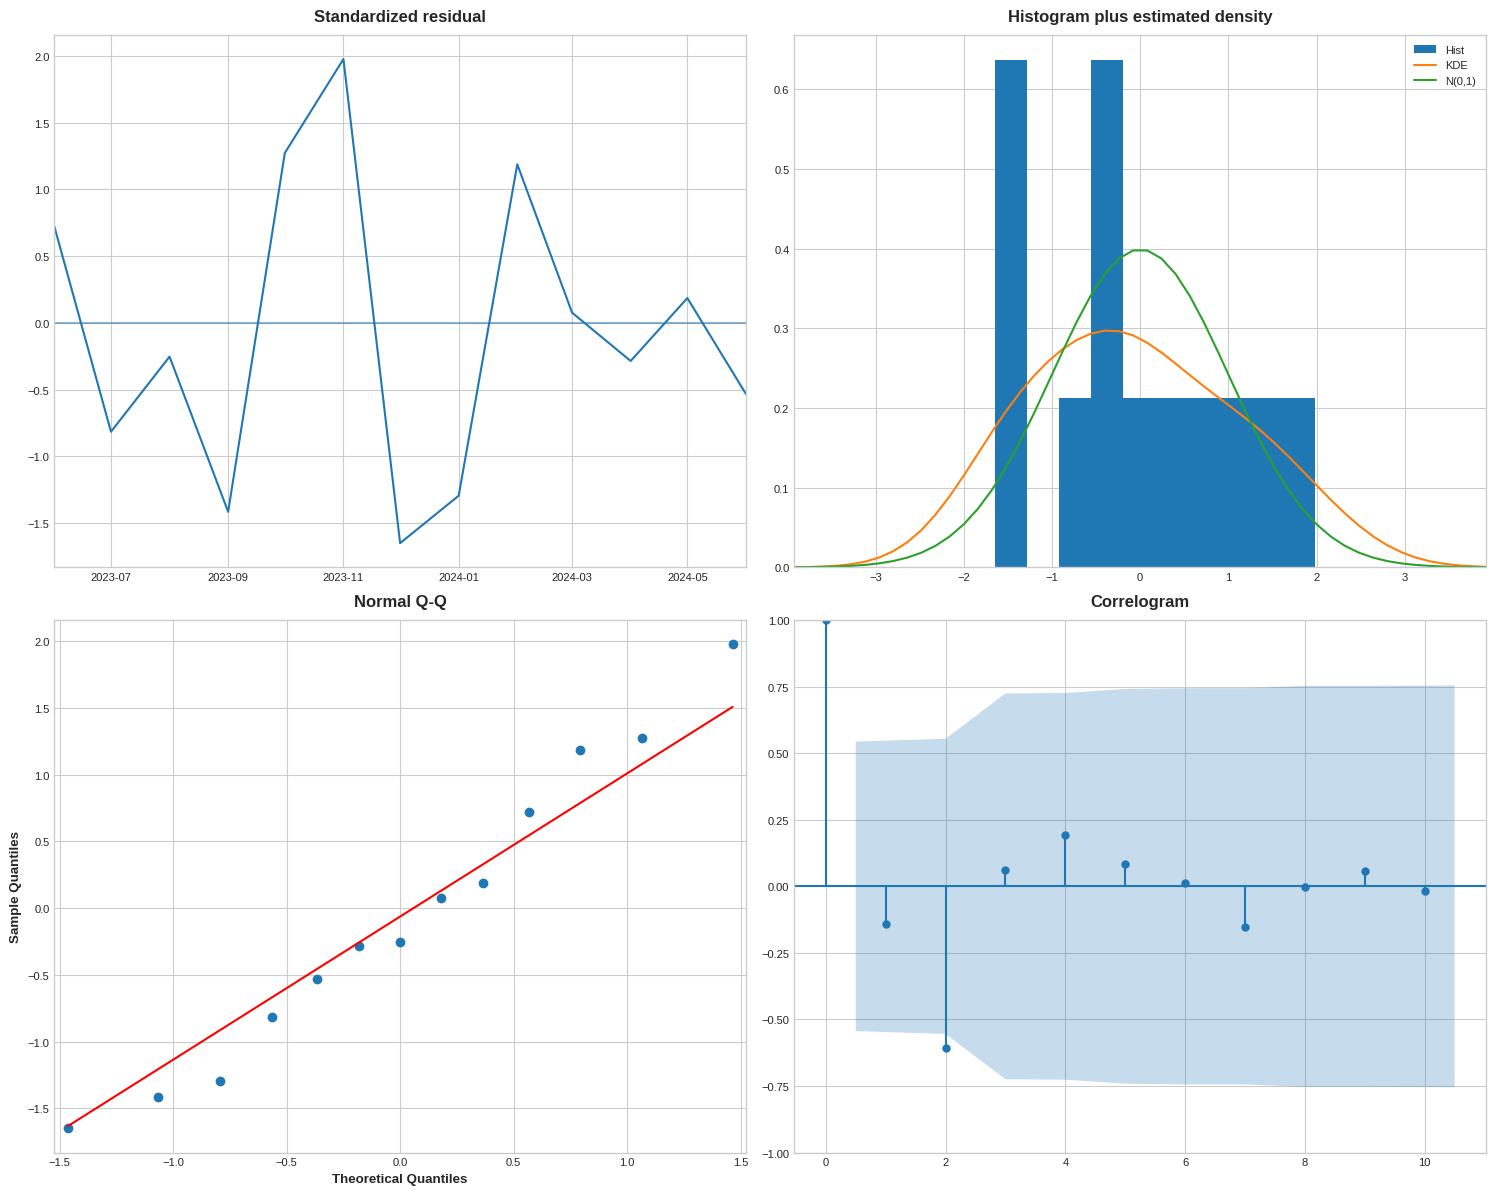

In [247]:
ARIMA_model.plot_diagnostics(figsize = (15, 12))
plt.show()

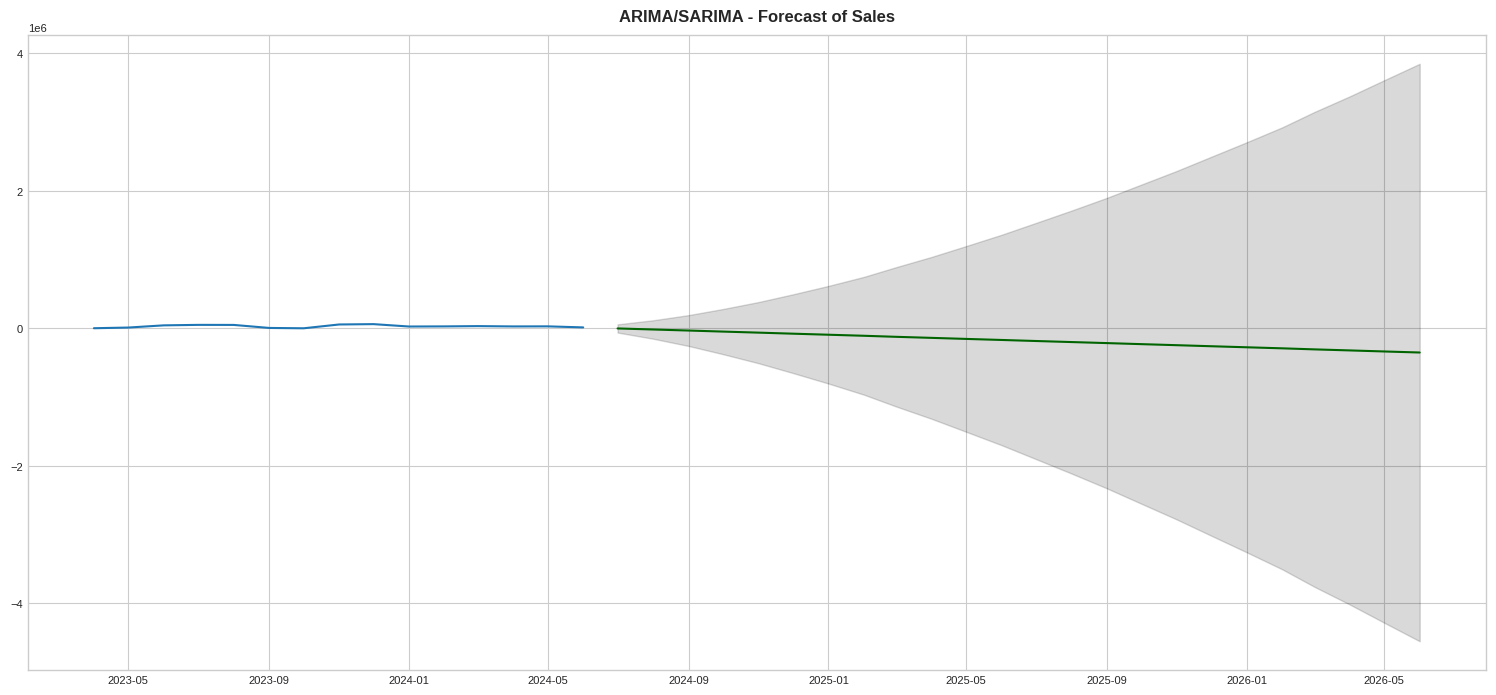

In [248]:
def forecast(ARIMA_model, periods = 24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods = n_periods, return_conf_int = True)
    index_of_fc = pd.date_range(sample_df.index[-1] + pd.DateOffset(months = 1), periods = n_periods, freq = 'MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index = index_of_fc)
    lower_series = pd.Series(confint[:, 0], index = index_of_fc)
    upper_series = pd.Series(confint[:, 1], index = index_of_fc)

    # Plot
    plt.figure(figsize = (15, 7))
    plt.plot(sample_df["qty"], color = '#1f76b4')
    plt.plot(fitted_series, color = 'darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color = 'k', alpha = .15)

    plt.title("ARIMA/SARIMA - Forecast of Sales")
    plt.show()

forecast(ARIMA_model)

### <center>SARIMA Model Selection</center>

Now let's try the same strategy as above, except let's use a SARIMA model so that can be account for seasonality.

In [412]:
sample_df = pivot.T[sample_sku].reset_index()
sample_df.drop(sample_df.tail(1).index, inplace=True)
sample_df.columns = ['month', 'qty']
sample_df['month'] = pd.to_datetime(sample_df['month'], infer_datetime_format = True)
sample_df = sample_df.set_index(['month'])
sample_df

,qty
month,
2023-04-01,"1,045"
2023-05-01,"10,869"
2023-06-01,"42,865"
2023-07-01,"49,898"
2023-08-01,"49,198"
2023-09-01,"5,159"
2023-10-01,130
2023-11-01,"55,647"
2023-12-01,"60,631"


<Figure size 500x300 with 0 Axes>

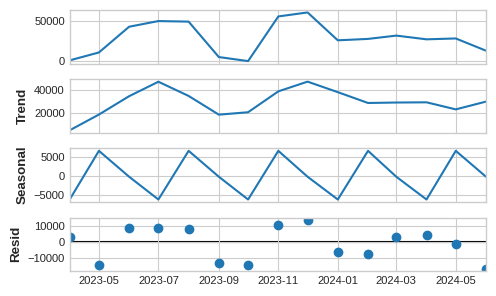

In [413]:
result = seasonal_decompose(sample_df, model='additive', extrapolate_trend='freq', period=3)

fig = plt.figure()
fig = result.plot()

In [414]:
result = adfuller(sample_df.qty.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-2.820602926328442
p-value:0.055390519868324536


The p-value is higher than 0.05. This means that the time serie is non stationary with a confidence of 95%. Then check if with a one step differentiation, the time serie become stationary (in terms of a trendless time series).

In [415]:
result2 = adfuller(sample_df.qty.diff().dropna())
print(f'ADF Statistics:{result2[0]}')
print(f'p-value:{result2[1]}')

ADF Statistics:-0.3332909288716318
p-value:0.9206552101542209


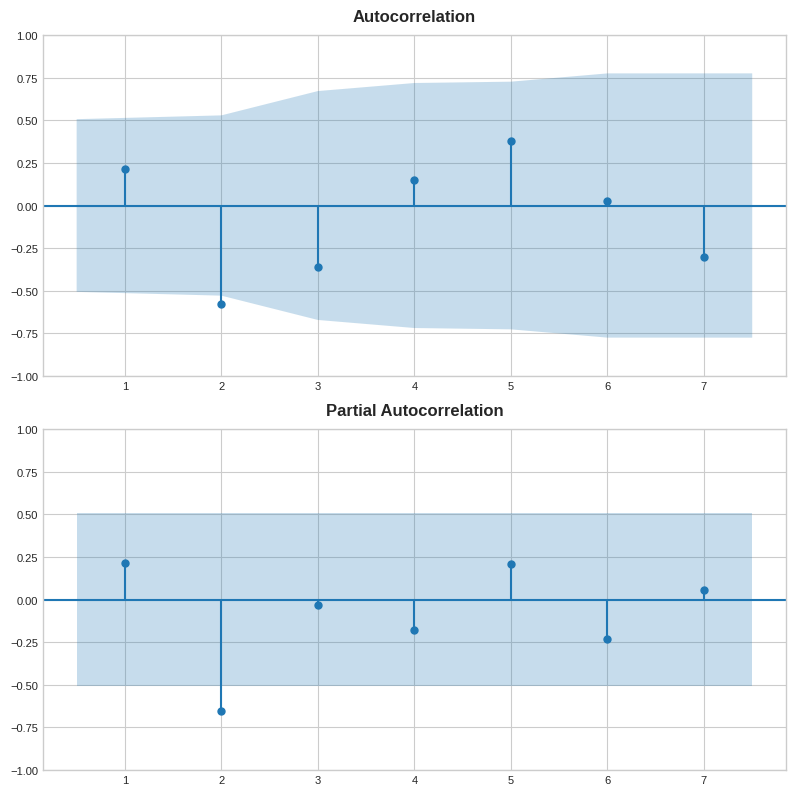

In [416]:
# @title ACF and PACF

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 8))

plot_acf(sample_df, lags = 7, zero = False, ax = ax1)
plot_pacf(sample_df, lags = 7, zero = False, ax = ax2)
plt.show()

In [417]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(sample_df, start_p = 1, start_q = 1,
                        max_p = 3, max_q = 3,
                        m = 6, # 6 is the half frequncy of the cycle
                        seasonal = True, # set to seasonal
                        d = 1,
                        D = 1, # order of the seasonal differencing
                        trace = True,
                        error_action = 'ignore',
                        start_P = 1, start_Q = 1,
                        max_P = 2, max_Q = 2,
                        information_criterion = 'aic',
                        stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=195.930, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=192.733, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=193.169, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=192.181, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[6]             : AIC=191.035, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[6]             : AIC=192.108, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[6]             : AIC=194.091, Time=0.21 sec
 ARIMA(1,1,1)(0,1,0)[6]             : AIC=192.902, Time=0.11 sec
 ARIMA(0,1,2)(0,1,0)[6]             : AIC=191.828, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=194.474, Time=0.05 sec
 ARIMA(1,1,2)(0,1,0)[6]             : AIC=193.630, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[6] intercept   : AIC=192.869, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,1,0)[6]          
Total fit time: 1.504 seconds


In [418]:
model = SARIMAX(sample_df.astype(float), order = (0, 1, 1), seasonal_order = (0, 1, 0, 6))
SARIMA_model = model.fit()

In [419]:
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                qty   No. Observations:                   15
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 6)   Log Likelihood                 -93.517
Date:                            Sun, 16 Jun 2024   AIC                            191.035
Time:                                    18:52:26   BIC                            191.194
Sample:                                04-01-2023   HQIC                           189.963
                                     - 06-01-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9309      1.121      0.830      0.406      -1.266       3.128
sigma2      1.401e+09   3.15e-10   4.45e+18      0.000     1.4e+09     1.4e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.55   Prob(JB):                         0.84
Heteroskedasticity (H):               1.04   Skew:                             0.26
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+35. Standard errors may be unstable.
"""

In [ ]:
# @title Create the 4 diagostics plots
SARIMA_model.plot_diagnostics(figsize = (8, 8))
plt.show()

In [422]:
# All the 4 plots indicates a good fit of the SARIMA model on the given time serie.
# Create a vector that will host the predictions
prediction = SARIMA_model.get_prediction(start = -12)
mean_prediction = prediction.predicted_mean
mean_prediction = mean_prediction.rename("prediction")

In [423]:
# Get the confidence intervals from the sarima prediction
confi_int_p = prediction.conf_int()
lower_limits_p = confi_int_p.iloc[:, 0]
upper_limits_p = confi_int_p.iloc[:, 1]

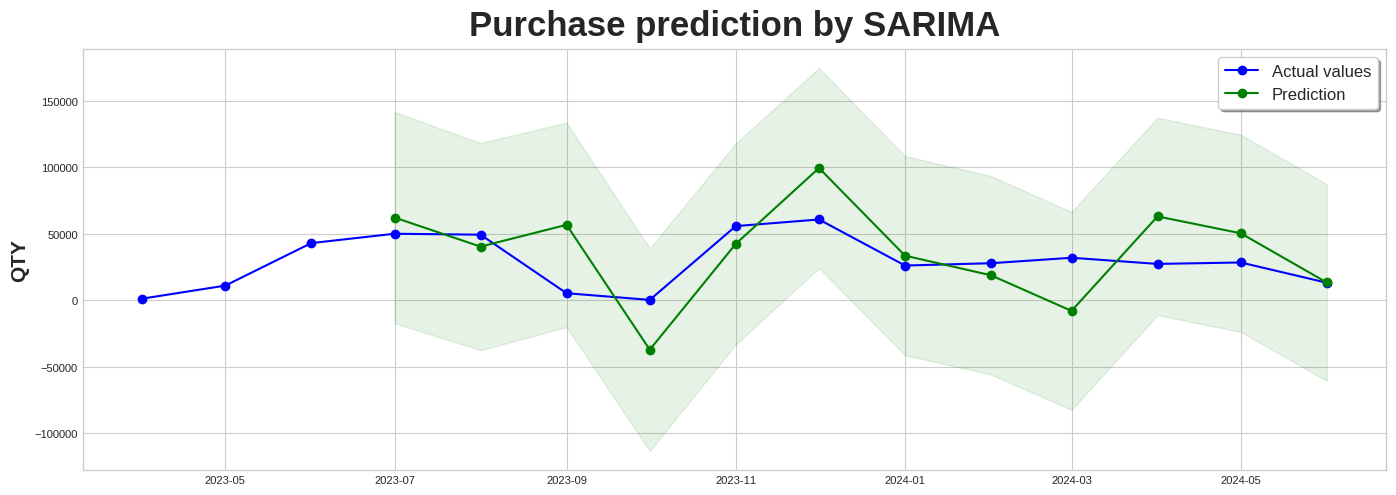

In [424]:
plt.figure(figsize = (14, 5))
plt.title("Purchase prediction by SARIMA", fontsize = 25)

plt.plot(sample_df[-24:].index, sample_df[-24:].values, label = 'Actual values', color = "blue", marker = "o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values, label = 'Prediction', color = "green", marker = "o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha = 0.1, color = "green")

plt.legend(fontsize = 12, fancybox = True, shadow = True, frameon = True)
plt.ylabel('QTY', fontsize = 15)
plt.show()

In [425]:
mape_sarima = mape(sample_df.iloc[-12:, 0], mean_prediction)
print(f"MAPE OF LSTM MODEL : {mape_sarima:.2f} %")

MAPE OF LSTM MODEL : 2529.44 %


In [426]:
rmse_sarima = sqrt(mean_squared_error(sample_df[-12:].values, mean_prediction.values))
print(f"RMSE OF LSTM MODEL : {rmse_sarima:.2f}")

RMSE OF LSTM MODEL : 28068.41


### SARIMA Forecast

In [427]:
# @title Make ARIMA forecast of next values
forecast = SARIMA_model.get_forecast(steps = 12)
mean_forecast = forecast.predicted_mean
mean_forecast = mean_forecast.rename("prediction")

In [428]:
confi_int_f = forecast.conf_int()
lower_limits_f = confi_int_f.iloc[:, 0]
upper_limits_f = confi_int_f.iloc[:, 1]

In [429]:
df_pred = train.iloc[-12:]

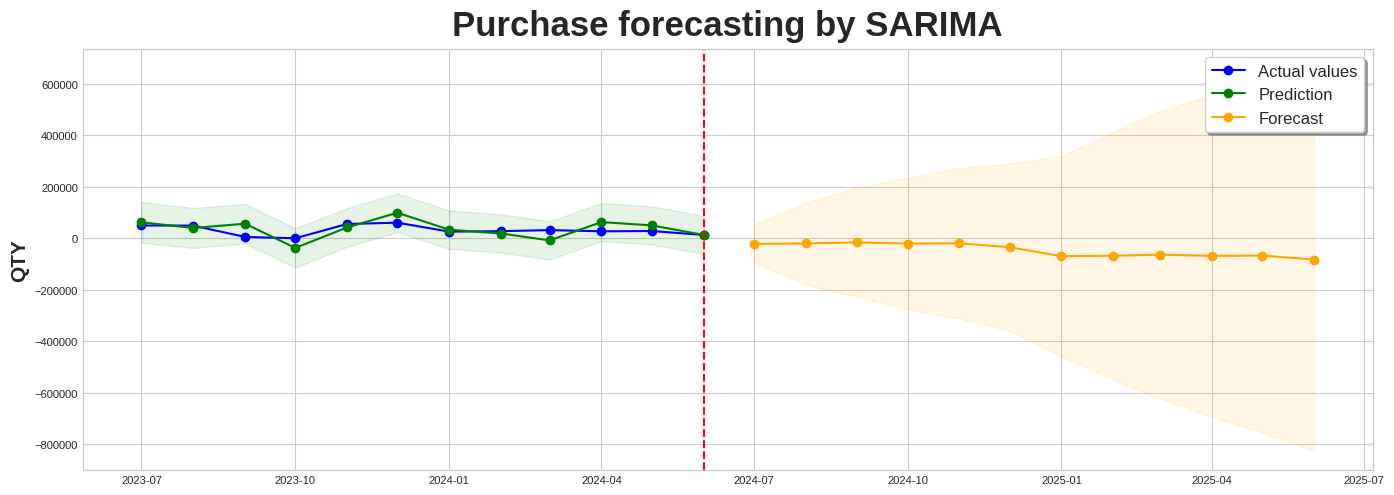

In [430]:
plt.figure(figsize = (14, 5))
plt.title("Purchase forecasting by SARIMA", fontsize = 25)

plt.plot(sample_df[-12:].index, sample_df[-12:].values, label = 'Actual values', color = "blue", marker = "o")

plt.plot(mean_prediction[-12:].index, mean_prediction[-12:].values, label = 'Prediction', color = "green", marker = "o")
plt.fill_between(mean_prediction[-12:].index, lower_limits_p, upper_limits_p, alpha = 0.1, color = "green")

plt.plot(mean_forecast[-12:].index,mean_forecast[-12:].values, label = 'Forecast', color = "orange", marker = "o")
plt.fill_between(mean_forecast[-12:].index, lower_limits_f, upper_limits_f, alpha = 0.1, color = "orange")

plt.axvline(df_pred.index[-1], color = "red", linestyle = "--")
plt.legend(fontsize = 12, fancybox = True, shadow = True, frameon = True)
plt.ylabel('QTY', fontsize = 15)
plt.show()

In [431]:
df_sarimax = pd.concat([mean_prediction, mean_forecast])

# Other SARIMA

In [ ]:
SARIMA_model = pm.auto_arima(sample_df["qty"], start_p = 1, start_q = 1,
                         test = 'adf', #'adf',
                         max_p = 3, max_q = 3,
                         m = 12, # 12 is the frequncy of the cycle
                         start_P = 0,
                         seasonal = True, # set to seasonal
                         d = None,
                         D = 1, # order of the seasonal differencing
                         trace = False,
                         error_action = 'ignore',
                         suppress_warnings = True,
                         stepwise = True)

The model diagnostics show some significant differences when compared with the standard ARIMA model.

Standardized residual
- The Standardized residual is much more consistent across the graph, meaning that the data is closer to being stationary.

Histogram plus KDE estimate
- The KDE curve is similar to the normal distribution (not much changed here).

Normal Q-Q
- The data points are clustered much closer to the line than in the ARIMA diagnostic plot.

Correlogram (ACF plot)
- The grey area is the confidence band, and if values fall outside of this then they are statistically significant. We want all values inside this area. Adding the seasonality component did this! All the points now fall within the 95% confidence interval.

In [ ]:
SARIMA_model.plot_diagnostics(figsize = (15, 12))
plt.show()

In [ ]:
forecast(SARIMA_model)

### <center>SARIMAX Model Selection</center>

Try to adding in an exogenous variable. In this simply going to add the month number as an exogenous variable, but this is not super useful as this is already conveyed through the seasonality.

In [ ]:
#adding exogenous variable
sample_df['month_index'] = sample_df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(sample_df[['qty']], exogenous = sample_df[['month_index']],
                           start_p = 1, start_q = 1,
                           test = 'adf',
                           max_p = 3, max_q = 3, m = 12,
                           start_P = 0, seasonal = True,
                           d = None, D = 1,
                           trace = False,
                           error_action = 'ignore',
                           suppress_warnings = True,
                           stepwise = True)

SARIMAX_model.summary()

In [ ]:
def sarimax_forecast(SARIMAX_model, periods = 24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(sample_df.index[-1], periods = n_periods, freq = 'MS').month},
                    index = pd.date_range(sample_df.index[-1]+ pd.DateOffset(months = 1), periods = n_periods, freq = 'MS'))

    fitted, confint = SARIMAX_model.predict(n_periods = n_periods,
                                            return_conf_int = True,
                                            exogenous = forecast_df[['month_index']])
    index_of_fc = pd.date_range(sample_df.index[-1] + pd.DateOffset(months = 1), periods = n_periods, freq = 'MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index = index_of_fc)
    lower_series = pd.Series(confint[:, 0], index = index_of_fc)
    upper_series = pd.Series(confint[:, 1], index = index_of_fc)

    # Plot
    plt.figure(figsize = (15, 7))
    plt.plot(sample_df["qty"], color = '#1f76b4')
    plt.plot(fitted_series, color = 'darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color = 'k', alpha = .15)

    plt.title("SARIMAX - Forecast of Sales")
    plt.show()

sarimax_forecast(SARIMAX_model, periods = 24)

# PyTorch LSTM RNN

The first thing must do is to properly shape the input data. When modeling a time series by LSTM RNN, it is crucial to to properly shape the input data in a sliding windows format.

The data is given as monthly data. then use a 12 steps prediction window. This means that use 12 samples of data (data of an entire year) to predict the 13th sample.

In [258]:
prediction_window = 12

In [273]:
n_input = 12 # Use 12 months data to predict 13 th month data

# dealing with an univariate time series, so n_features should be set to 1.
# In case of a multivariate time series, n_features should be set to a proper value higher than 1.
n_features = 4

# create a copy named "train" of the original dataframe "df" which will be used in the following.
train = sample_df.copy()

In [274]:
# use a RNN, it is recommended to rescale the data.
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

In [275]:
def sliding_windows(data, n_input):
    X_train=[]
    y_train=[]
    for i in range(n_input, len(data)):
        X_train.append(data[i-n_input:i])
        y_train.append(data[i])
    return np.array(X_train), np.array(y_train)

In [276]:
x, y = sliding_windows(scaled_train, prediction_window)

In [277]:
print(f'Given the Array: \n {x[0].flatten()}')
print(f'Predict this value: \n {y[0]}')

Given the Array: 
 [0.01512372        nan        nan 0.27272727 0.1775012         nan
        nan 0.36363636 0.70635196        nan        nan 0.45454545
 0.82259797        nan        nan 0.54545455 0.81102792        nan
        nan 0.63636364 0.08312259        nan        nan 0.72727273
 0.                nan        nan 0.81818182 0.9176212         nan
        nan 0.90909091 1.                nan        nan 1.
 0.42718302        nan        nan 0.         0.45604205        nan
        nan 0.09090909 0.5239087  0.         1.         0.18181818]
Predict this value: 
 [0.44741409 0.60037188 0.36086524 0.27272727]


In [278]:
train_size = int(len(train) - prediction_window*3)
val_size = len(train) - train_size

In [279]:
# convert the data to the tensor format required by PyTorch
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

X_train = Variable(torch.Tensor(np.array(x[:train_size])))
y_train = Variable(torch.Tensor(np.array(y[:train_size])))

X_valid = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
y_valid = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

### LSTM Modeling

In [280]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size = input_size, hidden_size = hidden_size,
            num_layers = num_layers, batch_first = True
        )

        self.fc1 = nn.Linear(hidden_size, 40)
        self.fc2 = nn.Linear(40, 1)
        self.relu = nn.ReLU()

    def forward(self,x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        _, (h_out,_) = self.lstm(x, (h0,c0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc2(self.relu(self.fc1(h_out)))

        return out

In [281]:
# set some parameters for the training
EPOCHS = 2000
LEARNING_RATE = 0.008
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

INPUT_SIZE = n_features
HIDDEN_SIZE = 100
NUM_LAYERS = 1

In [282]:
model = LSTMNet(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.to(DEVICE)
print(model)

LSTMNet(
  (lstm): LSTM(4, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
)


In [283]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

### LSTM Training Loop

In [ ]:
early_stopping_patience = 30
early_stopping_counter = 0

valid_loss_min = np.inf

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    model.train()
    output = model(X_train)

    train_loss = criterion(output, y_train)

    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
        model.eval()
        output_val = model(X_valid)
        valid_loss = criterion(output_val, y_valid)

        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), './state_dict.pt')
            print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
            valid_loss_min = valid_loss
            early_stopping_counter = 0 # reset counter if validation loss decreases
        else:
            print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
            early_stopping_counter += 1

        if early_stopping_counter > early_stopping_patience:
            print('Early stopped at epoch :', epoch)
            break

        print(f'\t Train_Loss: {train_loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')

### LSTM Prediction

In [ ]:
# check the values predicted by the LSTM RNN on the validation data
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

In [ ]:
valid_predict = model(X_valid)
y_pred_scaled = valid_predict.data.numpy()
y_pred = scaler.inverse_transform(y_pred_scaled)

In [ ]:
df_pred = train.iloc[-24:]
df_pred['prediction'] = y_pred

In [ ]:
plt.figure(figsize = (14, 5))
plt.plot(df_pred.index, df_pred["qty"], label = "actual", marker = "o")
plt.plot(df_pred.index, df_pred["prediction"], label = "predicted", marker = "o")
plt.title("Purchase prediction by LSTM RNN", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize = 14, fontsize = 13, fancybox = True, shadow = True, frameon = True)
plt.show()

In [ ]:
mape_lstm = mape(df_pred["qty"], df_pred["prediction"])
print(f"MAPE OF LSTM MODEL : {mape_lstm:.2f} %")

In [ ]:
rmse_lstm = mean_squared_error(df_pred["qty"], df_pred["prediction"], squared = False)
print(f"RMSE OF LSTM MODEL : {rmse_lstm:.2f}")

### LSTM Forecasting

In [ ]:
test_predictions = []

first_eval_batch = Variable(torch.Tensor(scaled_train[-n_input:])) # use the previous 12 samples to predict the 13th
current_batch = first_eval_batch.reshape((1, n_input, n_features)) # reshape the data into (1,12,1)
for i in range(len(scaled_train[-n_input:])):
    #get the prediction value for the first batch
    current_pred = model(current_batch)
    #append the prediction into the array
    test_predictions.append(current_pred)

    #use the prediction to update the batch and remove the first value
    current_batch = torch.cat((current_batch[:,1:,:], current_pred.reshape(1, 1, 1)), 1)

In [ ]:
forec_vals = [val.flatten().item() for val in test_predictions]
forec_vals = np.array(forec_vals).reshape(-1, 1)
forec_vals = scaler.inverse_transform(forec_vals)

In [ ]:
date_offset = 12
forecast_dates = (train.index + pd.DateOffset(months=date_offset))[-date_offset:]
forecast_dates

In [ ]:
df_forecast = pd.DataFrame({'month': forecast_dates})
df_forecast.set_index('month', inplace=True)
df_forecast['prediction'] = forec_vals
df_forecast.head(12)

In [ ]:
df_full = pd.concat([df_pred, df_forecast])

In [ ]:
plt.figure(figsize = (14, 5))
plt.plot(df_full.index, df_full["qty"], label = "Actual", marker = "o")
plt.plot(df_full.index, df_full["prediction"], label = "Predicted", marker = "o", color = "purple")
plt.axvline(df_pred.index[-1], color = "red", linestyle = "--")
plt.title("Purchase forecasting by LSTM RNN", fontsize = 25)
plt.ylabel('QTY', fontsize = 15)
plt.legend(title_fontsize = 14, fontsize = 13, fancybox = True, shadow = True, frameon = True)
plt.show()

# Results Sumamry

In [ ]:
plt.figure(figsize = (14, 5))
plt.title("Purchase forecasting by LSTM RNN and SARIMA models", fontsize = 20)
plt.plot(df[-24:].index, df[-24:].values, color = 'darkblue', label = 'Real')
plt.plot(df_sarimax.index, df_sarimax.values, color = 'darkorange', label = 'SARIMA', marker = 'o')
plt.plot(df_full.index, df_full['prediction'].values, color = 'green',label = 'LSTM', marker = 'o')
plt.axvline(df_pred.index[-1], color = "red", linestyle = "--")
plt.legend(bbox_to_anchor=(1, 1.03), fontsize = 16, fancybox = True, shadow = True, frameon = True)
# text = 'LSTM RMSE : {:.3f}\n\nSARIMA RMSE : {:.3f}\n\nLSTM MAPE : {:.2f} %\n\nSARIMA MAPE : {:.2f} %'.format(rmse_lstm, rmse_sarima, mape_lstm, mape_sarima)
# plt.text(mean_forecast.index[-1] + pd.DateOffset(days = 80), 90, text, fontsize = 16)
plt.ylabel('QTY', fontsize = 15)
plt.show()

In [ ]:
text = 'LSTM RMSE : {:.3f}, SARIMA RMSE : {:.3f}, LSTM MAPE : {:.2f} %, SARIMA MAPE : {:.2f} %'.format(rmse_lstm, rmse_sarima, mape_lstm, mape_sarima)
text